# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Overall & openSMILE emobase Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_opensmile_emnobase_features = pd.read_csv(get_deam_path('processed/features/integrated/normalised_essentia_best_overall_opensmile_emobase_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_emnobase_features = df_essentia_best_overall_opensmile_emnobase_features[df_essentia_best_overall_opensmile_emnobase_features.columns[1:]]

df_essentia_best_overall_opensmile_emnobase_features

,song_id,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,...,F0env_sma_de_linregerrQ,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3
0,2,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,...,0.427306,0.633121,0.052970,0.008991,0.546204,0.931732,0.403270,0.453796,0.401456,0.428889
1,3,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,...,0.141595,0.340520,0.068615,0.031988,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
2,4,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,...,0.399049,0.609771,0.048627,0.007233,0.706684,0.931732,0.238975,0.293316,0.237900,0.266529
3,5,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,...,0.416902,0.624603,0.046268,0.006583,0.578416,0.931732,0.412816,0.421584,0.410959,0.417262
4,7,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,...,0.291508,0.512783,0.052501,0.011769,0.740093,0.931732,0.256946,0.259907,0.255790,0.258448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,...,0.108314,0.291082,0.272948,0.173102,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1740,1997,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,...,0.023071,0.109289,0.090879,0.028913,0.962139,0.931732,0.000000,0.037861,0.000000,0.019198
1741,1998,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,...,0.139224,0.337426,0.046131,0.017807,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1742,1999,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,...,0.096113,0.271372,0.160770,0.069559,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000


In [4]:
df_essentia_best_overall_opensmile_emnobase_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 1125 columns):
 #     Column                                     Dtype  
---    ------                                     -----  
 0     song_id                                    int64  
 1     lowlevel.melbands_kurtosis.dmean           float64
 2     lowlevel.melbands_kurtosis.dmean2          float64
 3     lowlevel.melbands_kurtosis.dvar            float64
 4     lowlevel.melbands_kurtosis.dvar2           float64
 5     lowlevel.melbands_kurtosis.max             float64
 6     lowlevel.melbands_kurtosis.mean            float64
 7     lowlevel.melbands_kurtosis.median          float64
 8     lowlevel.melbands_kurtosis.min             float64
 9     lowlevel.melbands_kurtosis.stdev           float64
 10    lowlevel.melbands_kurtosis.var             float64
 11    lowlevel.melbands_skewness.dmean           float64
 12    lowlevel.melbands_skewness.dmean2          float64
 13    lowlevel.melba

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_opensmile_emobase_whole = pd.merge(df_essentia_best_overall_opensmile_emnobase_features, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_emobase_whole = df_essentia_best_overall_opensmile_emobase_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_emobase_whole

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3,valence_mean_mapped,arousal_mean_mapped
0,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,0.000016,...,0.052970,0.008991,0.546204,0.931732,0.403270,0.453796,0.401456,0.428889,-0.475,-0.500
1,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,0.000035,...,0.068615,0.031988,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,-0.375,-0.425
2,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,0.000004,...,0.048627,0.007233,0.706684,0.931732,0.238975,0.293316,0.237900,0.266529,0.175,0.125
3,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,0.000003,...,0.046268,0.006583,0.578416,0.931732,0.412816,0.421584,0.410959,0.417262,-0.150,0.075
4,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,0.000083,...,0.052501,0.011769,0.740093,0.931732,0.256946,0.259907,0.255790,0.258448,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,0.000001,...,0.272948,0.173102,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,-0.275,0.225
1740,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,0.000002,...,0.090879,0.028913,0.962139,0.931732,0.000000,0.037861,0.000000,0.019198,0.075,-0.275
1741,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,0.000005,...,0.046131,0.017807,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,0.350,0.300
1742,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,0.000003,...,0.160770,0.069559,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_opensmile_emnobase_features.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,F0env_sma_de_linregerrQ,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3
0,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,0.000016,...,0.427306,0.633121,0.052970,0.008991,0.546204,0.931732,0.403270,0.453796,0.401456,0.428889
1,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,0.000035,...,0.141595,0.340520,0.068615,0.031988,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
2,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,0.000004,...,0.399049,0.609771,0.048627,0.007233,0.706684,0.931732,0.238975,0.293316,0.237900,0.266529
3,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,0.000003,...,0.416902,0.624603,0.046268,0.006583,0.578416,0.931732,0.412816,0.421584,0.410959,0.417262
4,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,0.000083,...,0.291508,0.512783,0.052501,0.011769,0.740093,0.931732,0.256946,0.259907,0.255790,0.258448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,0.000001,...,0.108314,0.291082,0.272948,0.173102,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1740,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,0.000002,...,0.023071,0.109289,0.090879,0.028913,0.962139,0.931732,0.000000,0.037861,0.000000,0.019198
1741,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,0.000005,...,0.139224,0.337426,0.046131,0.017807,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1742,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,0.000003,...,0.096113,0.271372,0.160770,0.069559,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()
num_epochs = 300

Define the neural network

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [13]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 1124])


Training loop

In [14]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [15]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5586736661924706
Epoch 2, Loss: 0.557649895398549
Epoch 3, Loss: 0.556939028346024
Epoch 4, Loss: 0.5565194248963297
Epoch 5, Loss: 0.5563300085926458
Epoch 6, Loss: 0.5562872049126403
Epoch 7, Loss: 0.5563206874209357
Epoch 8, Loss: 0.5563780583623485
Epoch 9, Loss: 0.5564066612715622
Epoch 10, Loss: 0.5563870304069433
Epoch 11, Loss: 0.5563491325767285
Epoch 12, Loss: 0.556293392631972
Epoch 13, Loss: 0.5562182781732494
Epoch 14, Loss: 0.5561090440782631
Epoch 15, Loss: 0.5559597736976482
Epoch 16, Loss: 0.5557646702225705
Epoch 17, Loss: 0.5555044256629755
Epoch 18, Loss: 0.5551378275731997
Epoch 19, Loss: 0.5546303571898417
Epoch 20, Loss: 0.5538787587476712
Epoch 21, Loss: 0.5527999353786933
Epoch 22, Loss: 0.5513807510615691
Epoch 23, Loss: 0.5494431277444558
Epoch 24, Loss: 0.5466924635200738
Epoch 25, Loss: 0.5430333490159358
Epoch 26, Loss: 0.5384801953746298
Epoch 27, Loss: 0.532786503490417
Epoch 28, Loss: 0.5253649567073634
Epoch 29, Loss: 0.516833132670705

Epoch 36, Loss: 0.49029213918371
Epoch 37, Loss: 0.48734295528502397
Epoch 38, Loss: 0.4874420889667643
Epoch 39, Loss: 0.48593397905846575
Epoch 40, Loss: 0.48328916297154667
Epoch 41, Loss: 0.48150163982583516
Epoch 42, Loss: 0.47845992717839
Epoch 43, Loss: 0.4775705619673697
Epoch 44, Loss: 0.47919709862255006
Epoch 45, Loss: 0.47826646818730817
Epoch 46, Loss: 0.4746053405087893
Epoch 47, Loss: 0.47671703272047283
Epoch 48, Loss: 0.47628245958963444
Epoch 49, Loss: 0.4740293592814772
Epoch 50, Loss: 0.47605592350162734
Epoch 51, Loss: 0.47207456057321556
Epoch 52, Loss: 0.4730797596344531
Epoch 53, Loss: 0.4717435615840089
Epoch 54, Loss: 0.4710577424365745
Epoch 55, Loss: 0.47215255191411876
Epoch 56, Loss: 0.46992623255002286
Epoch 57, Loss: 0.4709437693005827
Epoch 58, Loss: 0.46963533399866814
Epoch 59, Loss: 0.469466091592084
Epoch 60, Loss: 0.4695322661936295
Epoch 61, Loss: 0.4684059788008794
Epoch 62, Loss: 0.4687286689991107
Epoch 63, Loss: 0.46745772249638823
Epoch 64, L

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [16]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 1124])


Generating scores

In [17]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute().item()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [18]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.20794055929563807
Test R^2 score: 0.5307036766713393


True values (test set)

In [19]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [20]:
test_pred

tensor([[ 1.8339e-01,  2.5638e-01],
        [-2.1725e-01, -2.8155e-01],
        [ 3.6771e-01,  2.9917e-01],
        [ 2.0235e-01,  2.8111e-01],
        [-6.3055e-02, -9.5239e-02],
        [-3.0903e-01, -3.8902e-01],
        [-4.2103e-01, -5.2009e-01],
        [ 3.4871e-01,  2.9292e-01],
        [-3.0940e-01, -3.8948e-01],
        [ 2.4152e-01,  3.0197e-01],
        [ 1.6335e-01,  2.2556e-01],
        [-1.1029e-01, -1.6262e-01],
        [-3.3350e-01, -4.1854e-01],
        [ 1.4883e-01,  2.0176e-01],
        [-1.3254e-01, -1.8987e-01],
        [-2.6715e-01, -3.3821e-01],
        [-3.7264e-01, -4.6341e-01],
        [-1.4465e-01, -2.0507e-01],
        [ 9.9922e-02,  1.2248e-01],
        [-2.3514e-01, -3.0158e-01],
        [-2.7617e-01, -3.4913e-01],
        [-1.6024e-01, -2.2312e-01],
        [-2.9366e-01, -3.7037e-01],
        [ 4.1241e-02,  4.2718e-02],
        [ 9.7127e-02,  1.1924e-01],
        [-8.1372e-02, -1.2208e-01],
        [ 1.4690e-01,  1.9770e-01],
        [ 6.6815e-02,  7.848

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [21]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [22]:
for num_epochs in num_epochs_list:
  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.568824813449621
Training completed.
Training completed.
Testing model...
Test RMSE: 0.31944865975893666
Test R^2 score: -0.11485313148323562
Num of epochs: 2
Epoch 1, Loss: 0.5593172736190655
Epoch 2, Loss: 0.5583248157942802
Training completed.
Training completed.
Testing model...
Test RMSE: 0.305309109739355
Test R^2 score: -0.0144504266494484
Num of epochs: 3
Epoch 1, Loss: 0.5648158666711519
Epoch 2, Loss: 0.5625288479083363
Epoch 3, Loss: 0.5605664665174553
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30854558357274636
Test R^2 score: -0.034628204852006794
Num of epochs: 4
Epoch 1, Loss: 0.566467571227646
Epoch 2, Loss: 0.5635281015292405
Epoch 3, Loss: 0.5611696936878167
Epoch 4, Loss: 0.5592950540026196
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30770648390052247
Test R^2 score: -0.0335998414154447
Num of epochs: 5
Epoch 1, Loss: 0.5632386126630673
Epoch 2, Loss: 0.5614103253092163
Epoch 3, Los

Epoch 10, Loss: 0.5564771177843425
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30381594259535105
Test R^2 score: -0.006358004291457275
Num of epochs: 11
Epoch 1, Loss: 0.5574911212214123
Epoch 2, Loss: 0.5568016220967326
Epoch 3, Loss: 0.5563883962876099
Epoch 4, Loss: 0.556203409451155
Epoch 5, Loss: 0.5561947559398217
Epoch 6, Loss: 0.5562775347891876
Epoch 7, Loss: 0.5563571676680318
Epoch 8, Loss: 0.5563905388387634
Epoch 9, Loss: 0.5563706395773913
Epoch 10, Loss: 0.5563165356993556
Epoch 11, Loss: 0.5562472643409923
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30380699927396665
Test R^2 score: -0.0058907596711397225
Num of epochs: 12
Epoch 1, Loss: 0.561761265022518
Epoch 2, Loss: 0.5600820867371995
Epoch 3, Loss: 0.5587059388506848
Epoch 4, Loss: 0.5576178021268915
Epoch 5, Loss: 0.5568595321938914
Epoch 6, Loss: 0.5563920118378956
Epoch 7, Loss: 0.5561912998558768
Epoch 8, Loss: 0.5562276814301608
Epoch 9, Loss: 0.5564133029352

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [23]:
import matplotlib.pyplot as plt

In [24]:
r2_scores_list

[-0.11485313148323562,
 -0.0144504266494484,
 -0.034628204852006794,
 -0.0335998414154447,
 -0.014428508182008692,
 -0.12671453961783807,
 -0.006560833435515057,
 -0.011656697542590466,
 -0.002551092185966941,
 -0.006358004291457275,
 -0.0058907596711397225,
 0.0005933168738296857,
 -0.023123586981551036,
 -0.0032436083185517495,
 -0.02477185869854548,
 -0.0036498800750841554,
 -0.0010957901296930195,
 0.0032859568156156094,
 -0.007949828622505262,
 0.01705484212733671,
 -0.0024032752784049483,
 -0.00011177214085927867,
 -0.0018901697861165578,
 0.07903405555958815,
 0.02644819610609861,
 0.020122451790988538,
 0.34863934960026144,
 -0.0007814765734425189,
 0.2081412191550024,
 -0.010166849390238486,
 0.31586818928244514,
 0.17763044926540927,
 -0.007409271461168654,
 0.34274160752332383,
 0.17166504666444748,
 0.28538927578351225,
 0.20627842035052618,
 -0.006919331170963772,
 0.4518911257420511,
 0.39457281311281445,
 0.4638729054387326,
 0.19750296816821516,
 0.105833863471605,
 0.4

Plot the line graph

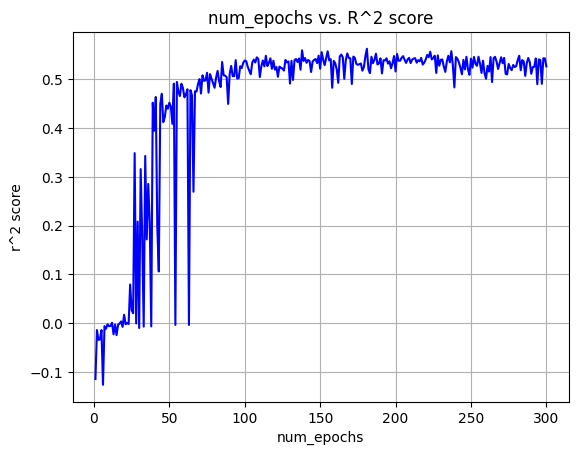

In [25]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [26]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5627554679488036
Corresponding RMSE: 0.20041272617917089
Corresponding num_epochs: 181
